Expectation maximization is an algorithm that allow us to maximize a likelihood function of probabilistic model  with respect to parameters. The probablistic model has both observed and hidden variables.

Particularly, given $p(X,Z\mid \theta),$ where $X$ are observed variables and $Z$ are hidden variables, our job is to maximize the likehood function $p(X \mid \theta)$ with respect to $\theta$. This is difficult since the values of $Z$ are hidden. If we know the values of $Z$ then it is often easy to optimize the likehood function.

We first describe the general expectation maximization algorithm and give a few examples later.

1. $\theta^{old} = \theta^{initial}$
2. **E-step:** Evaluate $p(Z \mid X, \theta^{old})$
3. **M-step:** Evaluate $\theta^{new}$ given by $\theta^{new} = argmax_{\theta} Q(\theta, \theta^{old}),$ where $Q(\theta, \theta^{old})$ are the expectation of complete log likelihood: $Q(\theta, \theta^{old}) = \sum_{Z}p(Z \mid X, \theta^{old})\ln p(X, Z \mid \theta)$
4. Check the convergence of either log likelihood or parameter values. If the convergence criterio is not satisfied then let $\theta^{old} = \theta^{new}$, repeat step 2.

In [165]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
from scipy.stats import multivariate_normal

plt.rcParams['figure.figsize'] = (12,8)

# A toy problem

Given a set of data $D = \{(x_{1n}, x_{2n}\}_{n=1}^{N}$, where we have values for every $x_{n1}$, the first dimension, and have only a partial observation on the second dimension $x_{2n}$. Assume that we these data follow a 2-dimensional Gaussian distribution, we will infer the values of missing (hidden) values in the second dimension.
$$\begin{pmatrix}x_{1}\\x_{2}\end{pmatrix} \sim \cal{N}(\begin{pmatrix}\mu_1\\\mu_2\end{pmatrix}, \begin{pmatrix}\sigma_1^2 \quad \rho \sigma_1\sigma_2\\\rho \sigma_1\sigma_2 \quad \sigma_2^2\end{pmatrix})$$


First we create a data set, where we have the luxury of knowing the true values. We delete part of the data along the second direction and try to recover it. We plot the samples below as blue circles. Now say we lose the y-values of the last-20 pieces of data. We are left with a missing data or hidden data or latent-variables problem. We plot both datasets below, with the y-values of the lost points set to 0

In [166]:
sig1=1
sig2=0.75
mu1=1.85
mu2=1
rho=0.82
means=np.array([mu1, mu2])
cov = np.array([
    [sig1**2, sig1*sig2*rho],
    [sig2*sig1*rho, sig2**2]
])
means, cov
np.random.seed(2018)

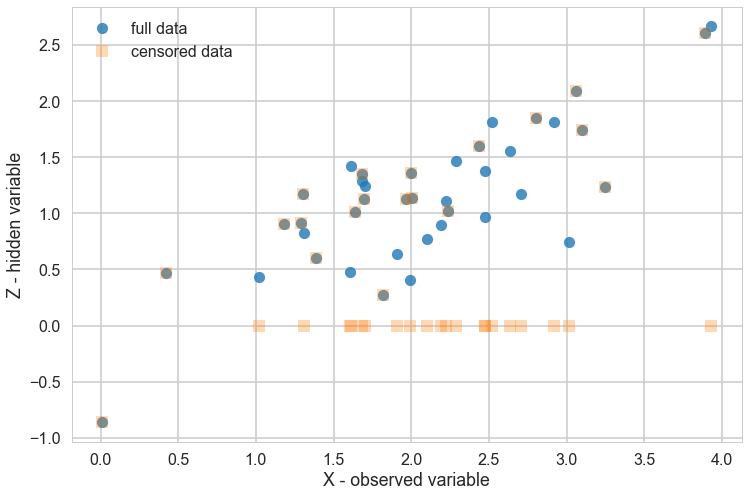

In [167]:
samples=np.random.multivariate_normal(means, cov, size=40)
samples_censored=np.copy(samples)
samples_censored[20:,1]=0
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8, label='full data')
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.3, label='censored data')
plt.gca().set_xlabel(r"X - observed variable")
plt.gca().set_ylabel(r"Z - hidden variable")
plt.legend();

If we have no hidden variables, i.e., complete data. Then it is easy to estimate the original Gaussian distribution. The maximum likelihood estimation is: $$\mu_{ML} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n$$

and $$\Sigma_{ML} = \frac{1}{N}\sum_{n=1}^{N}(\mathbf{x}_n - \mu_{ML})(\mathbf{x}_n - \mu_{ML})^{T}$$

In [185]:
def plot_gaussian(mean, cov, linestyles='solid'):
    x1 = np.linspace(-1, 5, 100)
    x2 = np.linspace(-1, 4, 100)
    X1, X2 = np.meshgrid(x1,x2)
    Z = np.array([X1, X2]).transpose(1,2,0)
    model = multivariate_normal(mean=mean, cov=cov)
    plt.contourf(X1, X2, model.pdf(Z), alpha = 0.2, linestyles=linestyles)
    

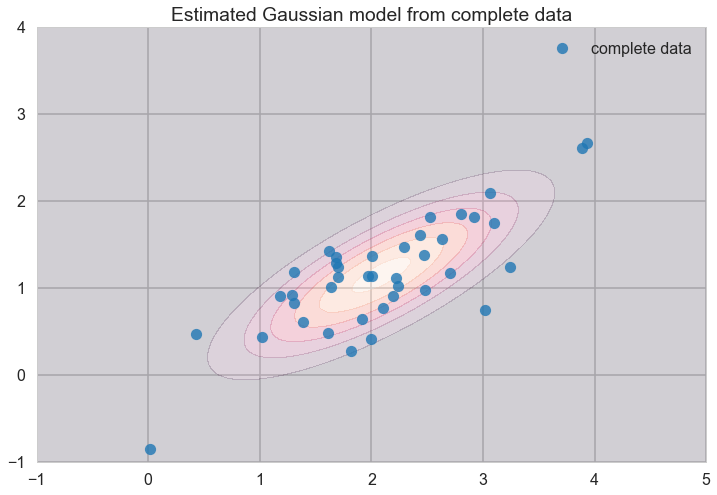

In [186]:
# MLE estimate N(x|mu, cov) from complete data
mu1 = lambda s: np.mean(s[:,0])
mu2 = lambda s: np.mean(s[:,1])
s1 = lambda s: np.std(s[:,0])
s2 = lambda s: np.std(s[:,1])
rho = lambda s: np.mean((s[:,0] - mu1(s))*(s[:,1] - mu2(s)))/(s1(s)*s2(s))

# plot model
true_empirical_mean = np.array([mu1(samples), mu2(samples)])
true_empirical_cov = np.array([[s1(samples)**2, rho(samples)*s1(samples)*s2(samples)],
                          [rho(samples)*s1(samples)*s2(samples), s2(samples)**2]])
plot_gaussian(true_empirical_mean, true_empirical_cov)

# plot complete data
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8, label='complete data')
plt.title('Estimated Gaussian model from complete data');
plt.legend();

But we don't. So we shall follow an iterative process to find them. 


Let's us remember the conditional gaussian distribution formula. That is:

$$\mathbf{x} = \begin{pmatrix}\mathbf{x}_a\\ \mathbf{x}_b\end{pmatrix} \sim \cal{N}(\mu, \Sigma),$$ where

$$\mu = \begin{pmatrix}\mu_a \\ \mu_b\end{pmatrix}$$

and $$\Sigma = \begin{pmatrix}\Sigma_{aa} \quad \Sigma_{ab}\\ \Sigma_{ba} \quad \Sigma_{bb}\end{pmatrix}$$

Then we have the conditional distribution $p(\mathbf{x}_a \mid \mathbf{x}_b)$ is a also Gaussian distribution with mean and covarviance as follows.

$$\mu_{a|b} =  \mu_a + \Sigma_{ab}\Sigma_{bb}^{-1}(\mathbf{x}_b - \mu_b)$$ and

$$\Sigma_{a|b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}$$

In [170]:
mu1s=[]
mu2s=[]
s1s=[]
s2s=[]
rhos=[]

Bur remember our data are missing in the y-direction. Assume 0 and go. Since we are using the MLE of the full-data likelihood, with this assumption we can use the MLE formulae. This is called M-step or maximization step since we used the MLE formulae

In [171]:
# perform MLE
mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))
mu1s,mu2s,s1s,s2s,rhos

([2.087091924389681],
 [0.5687353198998151],
 [0.8095441939356555],
 [0.7551576594592053],
 [0.3359937627277947])

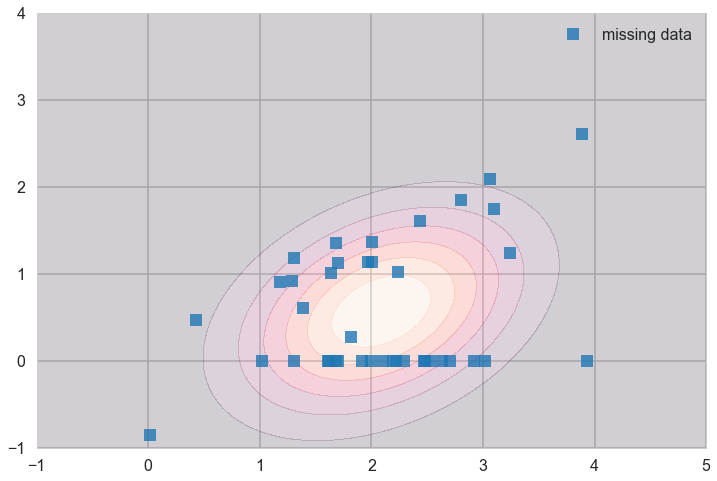

In [172]:
empirical_mean = np.array([mu1s[0], mu2s[0]])
empirical_cov = np.array([[s1s[0]**2, rhos[0]*s1s[0]*s1s[0]],
                          [rhos[0]*s1s[0]*s1s[0], s2s[0]**2]])
plot_gaussian(mean=empirical_mean, cov=empirical_cov)

# plot complete data
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.8, label='missing data')
plt.legend();

Now having new estimates of our parameters due to our (fake) y-data, lets go in the other direction. Using these parameters let us calculate new y-values.

One way we might do this is to replace the old-missing-y values with the means of these fixing the parameters of the multi-variate normal and the non-missing data. In other words:

In [173]:
# this is due to the discussion of conditional Gaussian
def ynew(x, mu1, mu2, s1, s2, rho):
    return mu2 + rho*(s2/s1)*(x - mu1)
    

In [174]:
newys=ynew(samples_censored[20:,0], mu1s[0], mu2s[0], s1s[0], s2s[0], rhos[0])
newys

array([0.41836441, 0.74052422, 0.23434226, 1.14648744, 0.44756033,
       0.5390403 , 0.69096987, 0.7048072 , 0.68980989, 0.51353001,
       0.42084781, 0.44114778, 0.82880611, 0.60175183, 0.32407001,
       0.7630257 , 0.6320556 , 0.61101177, 0.85921627, 0.57297278])

In [175]:
for step in range(1,20):
    # inferring hidden values
    samples_censored[20:,1] = newys
    #M-step
    mu1s.append(mu1(samples_censored))
    mu2s.append(mu2(samples_censored))
    s1s.append(s1(samples_censored))
    s2s.append(s2(samples_censored))
    rhos.append(rho(samples_censored))
    #E-step
    newys=ynew(samples_censored[20:,0], mu1s[step], mu2s[step], s1s[step], s2s[step], rhos[step])
df=pd.DataFrame.from_dict(dict(mu1=mu1s, mu2=mu2s, s1=s1s, s2=s2s, rho=rhos))
df

,mu1,mu2,rho,s1,s2
0,2.087092,0.568735,0.335994,0.809544,0.755158
1,2.087092,0.873244,0.660383,0.809544,0.580764
2,2.087092,1.035801,0.817495,0.809544,0.551689
3,2.087092,1.122437,0.870373,0.809544,0.558864
4,2.087092,1.168566,0.887767,0.809544,0.568971
5,2.087092,1.193114,0.894075,0.809544,0.576027
6,2.087092,1.206174,0.896641,0.809544,0.580235
7,2.087092,1.213120,0.897791,0.809544,0.582598
8,2.087092,1.216815,0.898342,0.809544,0.583890
9,2.087092,1.218780,0.898619,0.809544,0.584587


Voila. We converge to stable values of our parameters.
But they may not be the ones we seeded the samples with. The Em algorithm is only good upto finding local minima, and a finite sample size also means that the minimum found can be slightly different.

In [181]:
estimated_mean = df[['mu1', 'mu2']].iloc[19].values
rho = df.rho.iloc[19]
s1 = df.rho.iloc[19]
s2 = df.rho.iloc[19]
estimated_cov = np.array([[s1**2, rho*s1*s2],[rho*s1*s2, s2**2]])

In [184]:
plt.contourf?

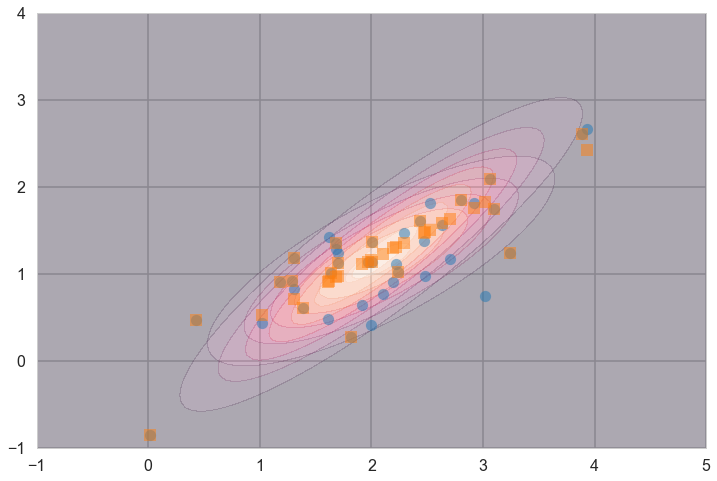

In [190]:
plt.plot(samples[:,0], samples[:,1], 'o', label='complete data', alpha=0.5)
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', label='inferred data', alpha=0.5)
plot_gaussian(true_empirical_mean, true_empirical_cov)
plot_gaussian(estimated_mean, estimated_cov, linestyles='dashdot')

We can see that Gaussian model that we learn using EM algorithm almost match the Gaussian
that we can learn if we have complete data.